#<strong>SriOryzaugur:</strong> Temporal Fusion Transformer 🤖</div>

---


            
<center>
<img src="https://www.researchgate.net/publication/355916352/figure/fig1/AS:1086496828334080@1636052438065/Temporal-Fusion-Transformer-architecture-4.ppm" width=700>
</center>

# **Table of contents**

1. [Install Packages 📥](#packages)
2. [Import Packages 📩](#import)
3. [Loading Dataset and Feature Engineering 🔬](#feature_engineering)
4. [Test Train Split 🪓](#split)
5. [Building and Training the Model 🏗️](#model)
6. [Testing 🧪](#test)

# **1. Install Packages 📥** <a class='anchor' id='packages'></a> [↑](#top)

In [1]:
!pip install torch pytorch-lightning pytorch_forecasting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 716.4/716.4 KB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.4/141.4 KB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.8/827.8 KB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.2/308.2 KB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 KB 66.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 70.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.7 MB/s eta 0:00:00
     ━━━━━

# **2. Import Packages 📩** <a class='anchor' id='import'></a> [↑](#top)

In [2]:
import matplotlib.pyplot as plt
plt.style.use("bmh")

import numpy as np
import pandas as pd

import pickle
import random
import tensorflow as tf 
import tensorboard as tb 
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch

In [5]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [20]:
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer, NaNLabelEncoder
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss, RMSE, MAPE
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [11]:
random.seed(30)
np.random.seed(30)
tf.random.set_seed(30)
torch.cuda.manual_seed(30)

# **3. Loading Dataset and Feature Engineering 🔬** <a class='anchor' id='feature_engineering'></a> [↑](#top)

In [6]:
from google.colab import drive

drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


In [7]:
df = pd.read_csv('/content/gdrive/My Drive/IIT 🎓/FYP/Dataset/processed_data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,index,Date,Price,Anuradhapura_Producer_Price,Kurunegala_Producer_Price,Polonnaruwa_Producer_Price,Producer_Price,Production,Production_Total,Exchange_Rate,Fuel_Price
0,0,1996-01-01,18.07,7.75,7.90,8.18,8.18,1333.6,2065.1,53.685,12.4
1,1,1996-02-01,18.70,8.17,8.26,8.76,8.76,1333.6,2065.1,53.685,12.4
2,2,1996-03-01,18.49,7.95,7.85,7.99,7.99,1333.6,2065.1,53.685,12.4
3,3,1996-04-01,18.52,8.25,8.01,8.29,8.29,1333.6,2065.1,54.735,12.4
4,4,1996-05-01,19.02,8.38,8.50,8.34,8.34,731.5,2065.1,54.950,12.4


In [42]:
# list of column names to concatenate
series_to_merge = ['Price', 'Producer_Price', 'Exchange_Rate', 'Fuel_Price']
num_of_series = len(series_to_merge)

In [43]:
# concatenate columns based on column names in cols_to_concat
combined_series = pd.concat([df[col] for col in series_to_merge], ignore_index=True)
combined_series.name = 'y'
combined_series = pd.DataFrame(combined_series)
combined_series

,y
0,18.07
1,18.70
2,18.49
3,18.52
4,19.02
...,...
1291,430.00
1292,430.00
1293,430.00
1294,430.00


In [44]:
combined_series['ds'] = pd.concat([df['Date']] * num_of_series).reset_index(drop=True)
combined_series

,y,ds
0,18.07,1996-01-01
1,18.70,1996-02-01
2,18.49,1996-03-01
3,18.52,1996-04-01
4,19.02,1996-05-01
...,...,...
1291,430.00,2022-08-01
1292,430.00,2022-09-01
1293,430.00,2022-10-01
1294,430.00,2022-11-01


In [45]:
combined_series.shape[0]

1296

In [46]:

series_arr = np.arange(num_of_series).reshape(-1, 1)
combined_series['series'] = np.repeat(series_arr, combined_series.shape[0]/num_of_series)
combined_series['series'] = combined_series['series'].astype(str)
combined_series

,y,ds,series
0,18.07,1996-01-01,0
1,18.70,1996-02-01,0
2,18.49,1996-03-01,0
3,18.52,1996-04-01,0
4,19.02,1996-05-01,0
...,...,...,...
1291,430.00,2022-08-01,3
1292,430.00,2022-09-01,3
1293,430.00,2022-10-01,3
1294,430.00,2022-11-01,3


In [47]:
combined_series = (combined_series.merge((combined_series[['ds']].drop_duplicates(ignore_index=True).rename_axis('time_idx')).reset_index(), on = ['ds']))
combined_series['month'] = combined_series['ds'].dt.month
combined_series['year'] = combined_series['ds'].dt.year
combined_series

,y,ds,series,time_idx,month,year
0,18.070,1996-01-01,0,0,1,1996
1,8.180,1996-01-01,1,0,1,1996
2,53.685,1996-01-01,2,0,1,1996
3,12.400,1996-01-01,3,0,1,1996
4,18.700,1996-02-01,0,1,2,1996
...,...,...,...,...,...,...
1291,430.000,2022-11-01,3,322,11,2022
1292,224.780,2022-12-01,0,323,12,2022
1293,117.000,2022-12-01,1,323,12,2022
1294,367.500,2022-12-01,2,323,12,2022


# **4. Test Train Split** 🪓 <a class='anchor' id='split'></a> [↑](#top)

In [63]:
train = combined_series[(combined_series["ds"] < pd.to_datetime("2020-01-01"))]

max_prediction_length = 12
max_encoder_length = train.ds.nunique()
training_cutoff = train["time_idx"].max() - max_prediction_length

print(max_encoder_length)
print(training_cutoff)

288
275


In [64]:
train.head()

,y,ds,series,time_idx,month,year
0,18.070,1996-01-01,0,0,1,1996
1,8.180,1996-01-01,1,0,1,1996
2,53.685,1996-01-01,2,0,1,1996
3,12.400,1996-01-01,3,0,1,1996
4,18.700,1996-02-01,0,1,2,1996


In [65]:
# Let's create a Dataset
training = TimeSeriesDataSet(
    train[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="y",
    group_ids=['series'], 
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    max_prediction_length=12,
    static_categoricals=['series'],
    time_varying_known_reals=['month', 'year'],
    time_varying_unknown_reals=['y'],
    target_normalizer=GroupNormalizer(
        groups=['series'], transformation='softplus'
    ),  # use softplus and normalize by group
    categorical_encoders={'series': NaNLabelEncoder().fit(combined_series.series)},
    lags={'y': [3, 6, 12]},
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True, 
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, train, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [33]:
# create a new study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=10,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(30, 128),
    hidden_continuous_size_range=(30, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False
)

# save study results
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# print best hyperparameters
print(study.best_trial.params)

[I 2023-04-04 14:14:42,125] A new study created in memory with name: no-name-b57f0878-e384-4ef7-96d4-27b8b6f92dd6
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-04 14:14:45,214] Trial 0 finished with value: 254.7712860107422 and parameters: {'gradient_clip_val': 0.3052807695814626, 'hidden_size': 47, 'dropout': 0.2779278307995

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-33-7f7b2f2c6c5a>", line 2, in <cell line: 2>
    study = optimize_hyperparameters(
  File "/usr/local/lib/python3.9/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py", line 217, in optimize_hyperparameters
    study.optimize(objective, n_trials=n_trials, timeout=timeout)
  File "/usr/local/lib/python3.9/dist-packages/optuna/study/study.py", line 400, in optimize
    _optimize(
  File "/usr/local/lib/python3.9/dist-packages/optuna/study/_optimize.py", line 66, in _optimize
    _optimize_sequential(
  File "/usr/local/lib/python3.9/dist-packages/optuna/study/_optimize.py", line 163, in _optimize_sequential
    trial = _run_trial(study, func, catch)
  File "/usr/local/lib/python3.9/dist-packages/optuna/study/_optimize.py", line 264, in _run_trial


TypeError: ignored

**Last Hyperparameter Result**

```
{'gradient_clip_val': 0.054046277250928754, 'hidden_size': 114, 'dropout': 0.13864619359066419, 'hidden_continuous_size': 75, 'attention_head_size': 1, 'learning_rate': 0.09140299245864647}
```

**Last Hyperparameter Result** (W Production T)

```
{
   "gradient_clip_val":0.821352550115402,
   "hidden_size":113,
   "dropout":0.1646939509327954,
   "hidden_continuous_size":46,
   "attention_head_size":2,
   "learning_rate":0.0016895193813204448
}

```




# **5. Building and Training the Model 🏗️** <a class='anchor' id='model'></a> [↑](#top)

In [66]:
#let's see how a naive model does

actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

4.3000359535217285

In [67]:
sm = SMAPE()
print(f"Median loss for naive prediction on validation: {sm.loss(actuals, baseline_predictions).mean(axis = 1).median().item()}")

Median loss for naive prediction on validation: 0.02769089676439762


In [68]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=100,
    accelerator='gpu',
    devices=1,
    enable_model_summary=False,
    gradient_clip_val=0.054046277250928754,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[],
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.09140299245864647,
    hidden_size=114,
    attention_head_size=1,
    dropout=0.13864619359066419,
    hidden_continuous_size=75,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Number of parameters in network: 1090.7k


In [69]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


# **6. Testing 🧪** <a class='anchor' id='testing'></a> [↑](#top)

In [72]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader, mode="prediction")
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

sm = SMAPE()
print(f"Validation median SMAPE loss: {sm.loss(actuals, predictions).mean(axis = 1).median().item()}")

rmse = RMSE()
print(f"Validation MSE loss: {rmse(predictions, actuals)}")

Validation median SMAPE loss: 0.06769309937953949
Validation MSE loss: 9.22108268737793


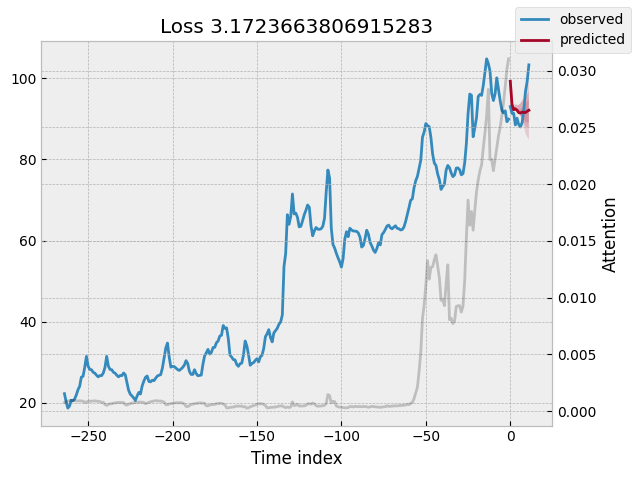

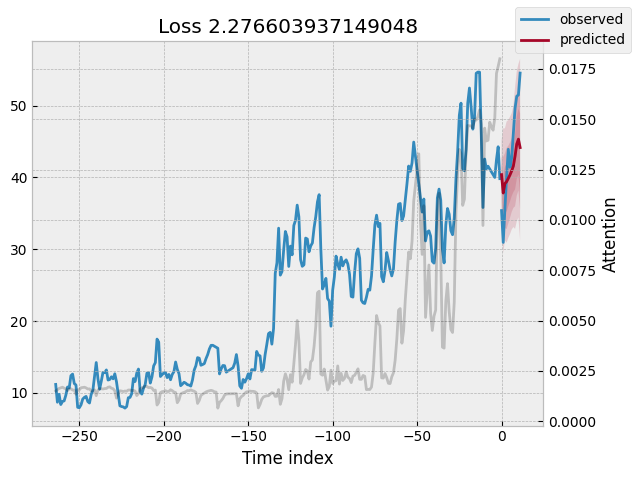

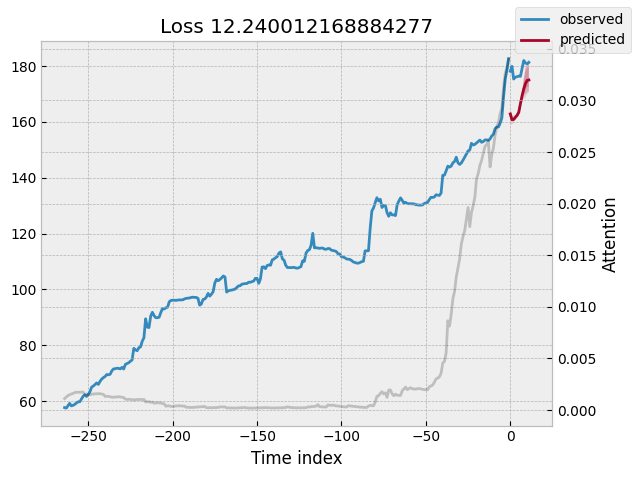

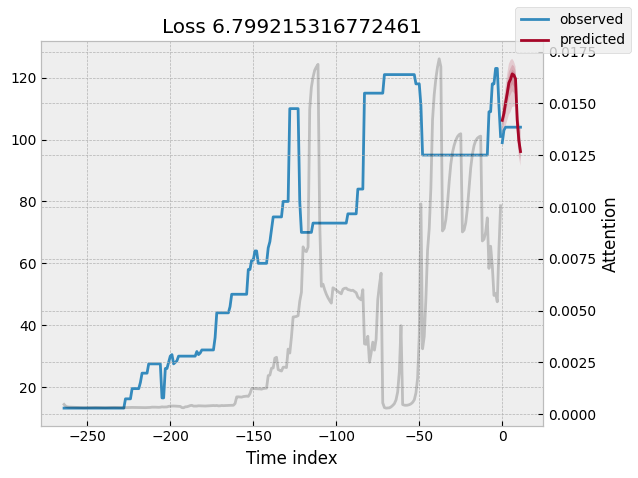

In [73]:
for idx in range(num_of_series):
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

In [74]:
predictions

tensor([[ 99.2469,  93.5570,  92.2048,  92.4688,  92.1117,  91.5227,  91.4174,
          91.6357,  91.5811,  91.5383,  91.8585,  92.1003],
        [ 40.3832,  37.8274,  39.1473,  39.4042,  39.8663,  40.3519,  40.9110,
          41.5851,  42.9634,  44.6383,  45.3259,  44.1574],
        [162.8391, 160.7809, 160.8727, 161.6386, 162.3043, 163.4222, 166.5270,
         169.4030, 171.8777, 173.7329, 174.8707, 175.0093],
        [106.2208, 108.4552, 111.8878, 114.9367, 118.3509, 119.4939, 121.2183,
         120.8319, 119.6706, 106.3901,  99.7019,  96.1325]])

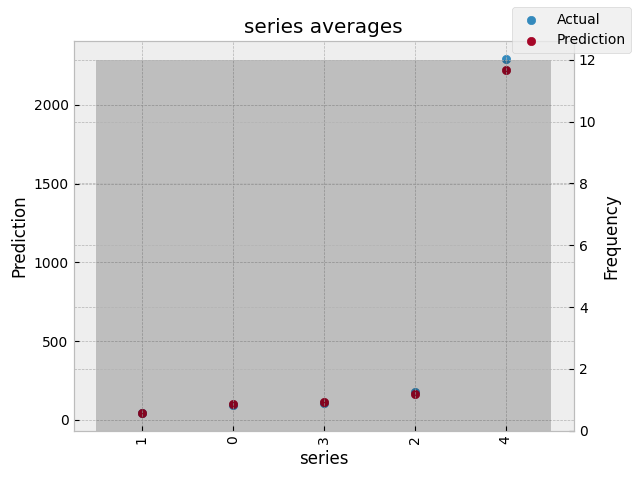

In [ ]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals, name='series');

**Stop Runtime 🛑**

In [ ]:
from google.colab import runtime
# runtime.unassign()

In [ ]:
data = df[['Price', 'Producer_Price']]
data

,Price,Producer_Price
0,18.07,8.18
1,18.70,8.76
2,18.49,7.99
3,18.52,8.29
4,19.02,8.34
...,...,...
319,239.24,122.93
320,228.44,117.00
321,224.78,117.00
322,224.78,117.00


In [ ]:
data.dtypes

Price             float64
Producer_Price    float64
dtype: object

In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

# Set the time series data as the index
# data.set_index('Date', inplace=True)

# Perform Granger Causality test using statsmodels
gc_res = grangercausalitytests(data, maxlag=1, verbose=False)

# Print the F-statistics and p-values for each lag
for lag in gc_res.keys():
    print(f'Lag {lag}: F-stat = {gc_res[lag][0]["params_ftest"][0]:.4f}, p-value = {gc_res[lag][0]["params_ftest"][1]:.4f}')


Lag 1: F-stat = 121.5082, p-value = 0.0000
